In [1]:
pip --version

pip 20.0.2 from /Users/jbanerje/opt/anaconda3/lib/python3.7/site-packages/pip (python 3.7)
Note: you may need to restart the kernel to use updated packages.


In [2]:
%%capture
pip install prometheus-api-client

In [3]:
%%capture
pip install matplotlib

In [4]:
from prometheus_api_client import *
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import datetime
import pandas
import seaborn as sns
# Set default Seaborn style
sns.set(style="darkgrid")
sns.set_context("talk", font_scale=1.4)
## hides ipython warnings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30, 10)
#plt.rcParams['figure.figsize'] = (20, 5)

# Creates SLI and derives SLO from SLI

## SLI Definition

**Percentage of transactions for mutating API calls that get completed by the Kube API Server below 1 sec**

`
The percentage of sufficiently fast requests of mutating API calls, as measured at the API Server.
“Sufficiently fast” is defined as < 1 second
Evaluation interval is 5min
Mutating calls are: POST, PUT, DELETE and PATCH requests
`

For each 5min interval, we calculate
count of mutating http_requests with a duration less than or equal to "1.0" seconds divided by count of all mutating http_requests
And we plot this over a period of time as defined in SLO

```
sum(increase(apiserver_request_duration_seconds_bucket{apiserver="kube-apiserver",le="1",verb=~"POST|PUT|DELETE|PATCH"}[5m])) / sum(increase(apiserver_request_duration_seconds_count{apiserver="kube-apiserver",verb=~"POST|PUT|DELETE|PATCH"}[5m]))
```
`increase` could have replaced by `rate` as well. Result would be same.


## SLO Definition
99% ≤1 second over any five-minute period AND 99% of those are satisfied in a rolling 7 and 28 day period.

In that 7 day period, we consider a 5 min interval a success if the SLI above returned 99% or higher
And aggregate of all 5 min interval to pass that threshold must be 99% of all 5 min interval in the SLO time period

Note - only considering 7 day scenario below. It would work perfectly well if we changed the settings to 28 days.


### Sets the connection details

In [5]:
# URL of the route call rbac-query-proxy 
# created in namespace:open-cluster-management-observability
# after installing Observability on Advanaced Cluster Managment Install
#url = "https://prometheus-k8s-openshift-monitoring.apps.xxx.com/"
url = "https://prometheus-k8s-openshift-monitoring.apps.crucial-midge.dev05.red-chesterfield.com"
# bearer token obtained from command `oc whoami -t`
token = "sha256~e60p_taLCpibVxpy_p06qnngg9OA0CuhYgMHVmyiLX8"
#connects to Thanos or Prometheus as dictated by the URL
pc = PrometheusConnect(url=url, headers={"Authorization": "Bearer {}".format(token)}, disable_ssl=True);

### Sets the time range and time step for all queries below

In [10]:
#datetime.datetime(year, month, day, hour=0, minute=0, second=0, microsecond=0, tzinfo=None, *, fold=0)
#today = datetime.datetime.today()
#end_time=datetime.datetime(year=today.year, month=today.month,day=today.day, hour=0, second=0) 
#start_time=(end_time - datetime.timedelta(minutes=60))
start_time=(datetime.datetime.now() - datetime.timedelta(minutes=10080))
end_time=datetime.datetime.now()
#interval between data points gathered
step='30m'

### Calculates the SLI

                     value
timestamp                 
2021-08-19 15:17:33    1.0
2021-08-19 15:47:33    1.0
2021-08-19 16:17:33    1.0
2021-08-19 16:47:33    1.0
2021-08-19 17:17:33    1.0
value    337
dtype: int64


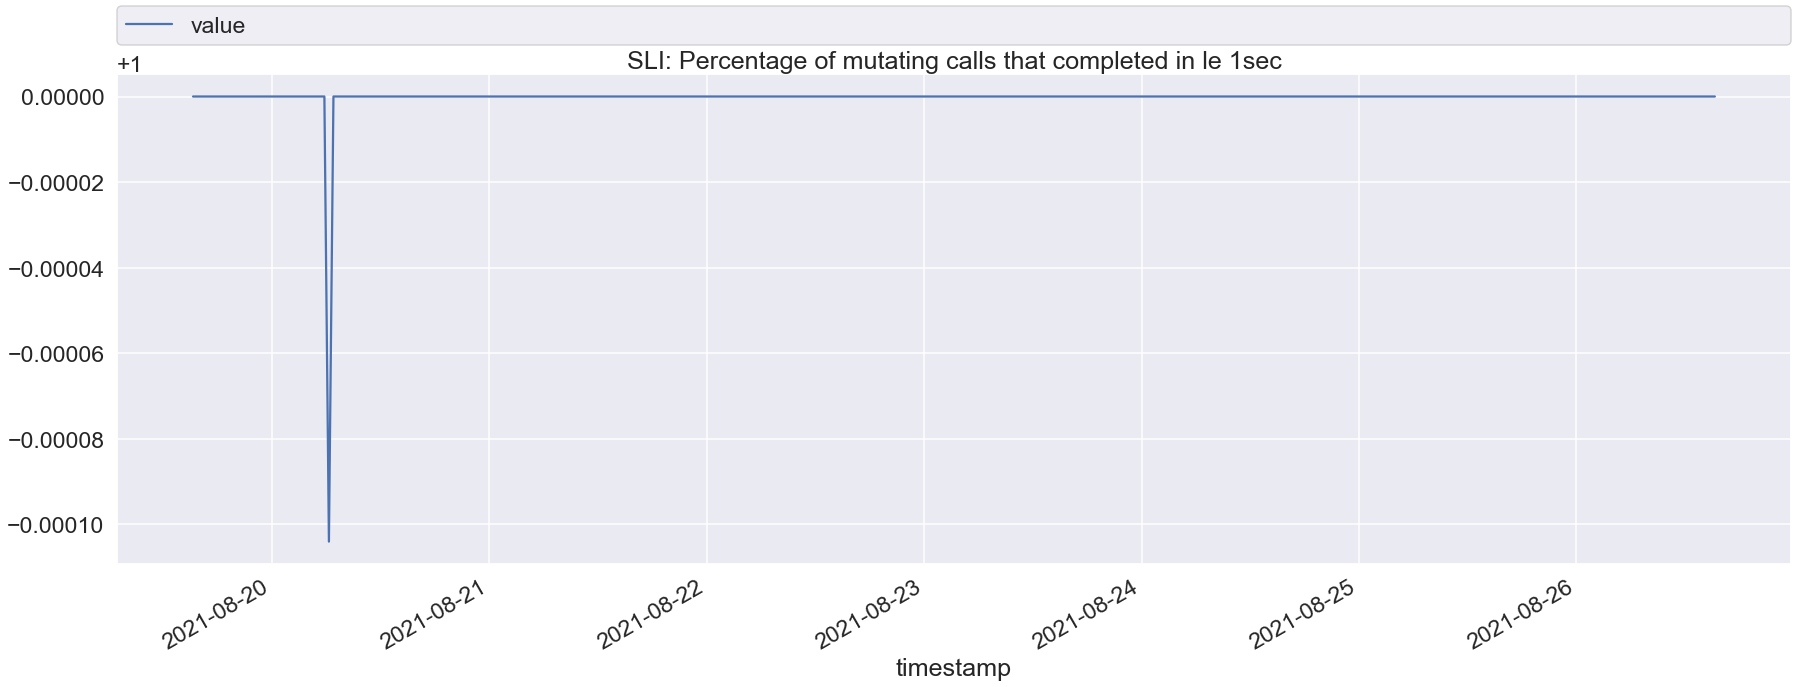

In [11]:
# PromQL being run: count(ALERTS{alertstate="firing"}) by (cluster,alertname)
sli = pc.custom_query_range(
    #query='sum(rate(apiserver_request_total{apiserver="kube-apiserver",code!~"5.."}[5m]))/sum(rate(apiserver_request_total{apiserver="kube-apiserver"}[5m]))',
    query='sum(increase(apiserver_request_duration_seconds_bucket{apiserver="kube-apiserver",le="1",verb=~"POST|PUT|DELETE|PATCH"}[5m])) / sum(increase(apiserver_request_duration_seconds_count{apiserver="kube-apiserver",verb=~"POST|PUT|DELETE|PATCH"}[5m]))',
    start_time=start_time,
    end_time=end_time,
    step=step,
)

sli_df = MetricRangeDataFrame(sli);
sli_df["value"]=sli_df["value"].astype(float)
sli_df.index= pandas.to_datetime(sli_df.index, unit="s")

print(sli_df.head())
print(sli_df.count())


ax=sli_df.plot(title="SLI: Percentage of mutating calls that completed in le 1sec")
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.show()



### Create a new column called result
```
if (SLI value in one interval (or 1 observation or 1 step0)) >=0.990 :
then 
    set result value =1
else 
    set result value = 0
```

                     value  result
timestamp                         
2021-08-19 15:17:33    1.0       1
2021-08-19 15:47:33    1.0       1
2021-08-19 16:17:33    1.0       1
2021-08-19 16:47:33    1.0       1
2021-08-19 17:17:33    1.0       1
Breakdown of result columm--
1    337
Name: result, dtype: int64


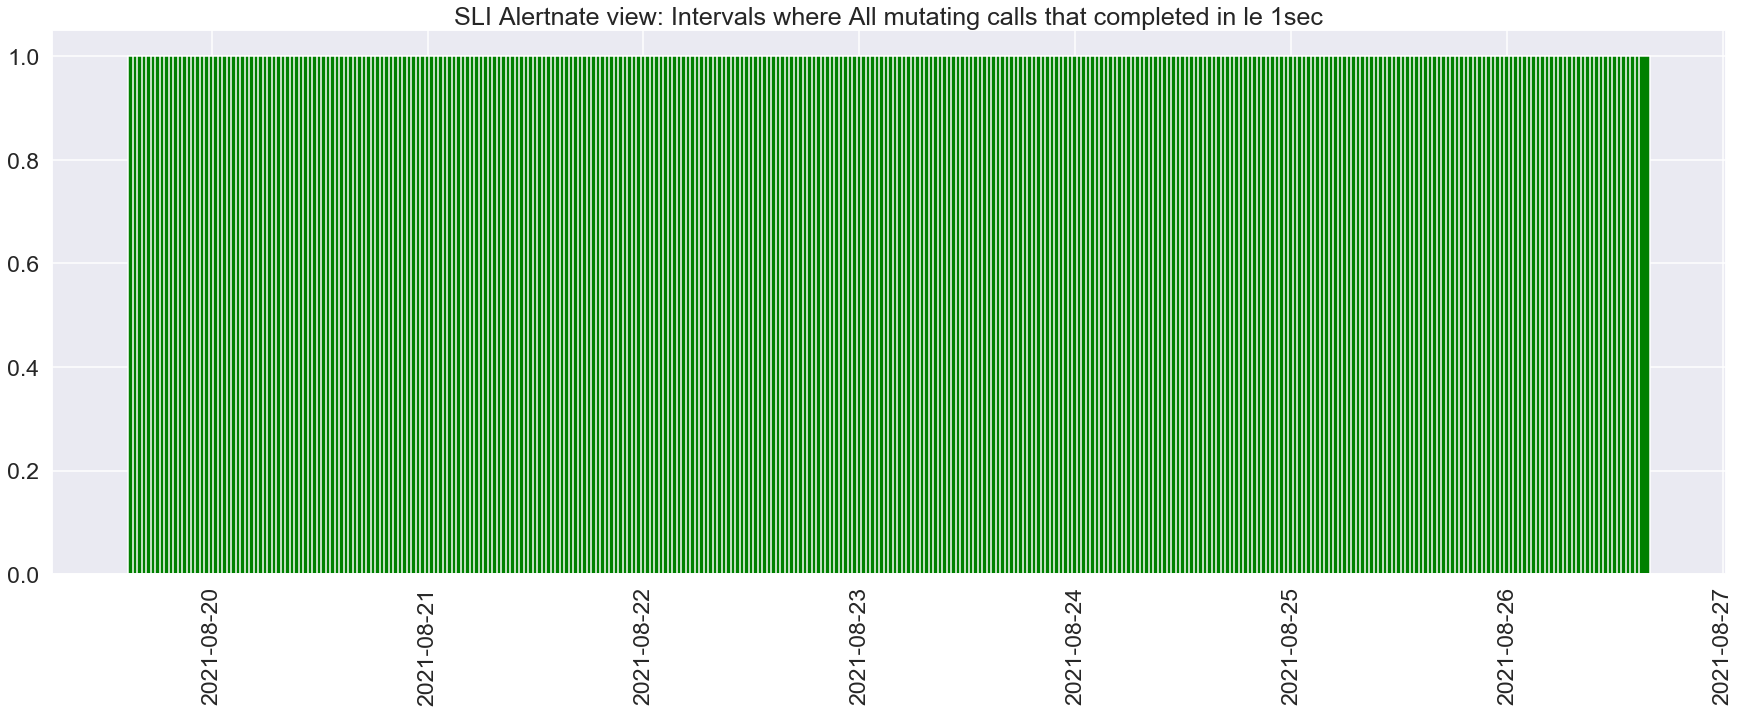

In [12]:
sli_df['result'] = np.where(sli_df['value'] >= 0.9900, 1, 0)
print(sli_df.head())
#print(sli_df.count())
print("Breakdown of result columm--")
print(sli_df['result'].value_counts())

#ax=sli_df['result'].plot(title="SLI Alertnate view: Intervals where All mutating calls that completed in le 1sec",color="green")
#ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
#ax.set(facecolor = "red")

f, ax = plt.subplots()
ax.bar(sli_df.index, sli_df['result'],color="green", width=0.05)
ax.set(title="SLI Alertnate view: Intervals where All mutating calls that completed in le 1sec")
#ax.set(facecolor = "red")
plt.xticks(rotation=90)
plt.show()

### SLO Calculation

In [13]:
total_hi = sli_df['result'].sum()
print("Sum of all times when the result=1: ", total_hi)
total_count = sli_df['result'].count()
print("Count of all observations (should be (12*24*7)+1=2017): ",total_count)
pct_slo = total_hi/total_count
print("SLO Value for last 7 days: ", pct_slo * 100)

Sum of all times when the result=1:  337
Count of all observations (should be (12*24*7)+1=2017):  337
SLO Value for last 7 days:  100.0
